## Beijing PM2.5 Data 
- 미세먼지 예측하기
- 시계열 데이터
- 일주일간의 기상 기록을 이용해 다음날 24시간의 미세먼지 수준을 예측해 봅니다

https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
TARGET_COLUMN = 'pm2.5'
path = '/home/sogangori/Downloads/dataset/machine learning dataset/PRSA_data_2010.1.1-2014.12.31.csv'

sequence_train = 7 * 24
sequence_test = 1 * 24

### only for test speed
- 학습 속도를 위해서 데이터는 1천개로 제한하겠습니다.

In [3]:
restrict_dataset_m = 1000

In [4]:
df = pd.read_csv(path)
df.shape

(43824, 13)

In [5]:
df = df[:restrict_dataset_m]
df.shape

(1000, 13)

In [6]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


## Look around
- 데이터를 훝어보면서 특징을 파악합니다

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
No       1000 non-null int64
year     1000 non-null int64
month    1000 non-null int64
day      1000 non-null int64
hour     1000 non-null int64
pm2.5    909 non-null float64
DEWP     1000 non-null int64
TEMP     1000 non-null float64
PRES     1000 non-null float64
cbwd     1000 non-null object
Iws      1000 non-null float64
Is       1000 non-null int64
Ir       1000 non-null int64
dtypes: float64(4), int64(8), object(1)
memory usage: 101.6+ KB


### 누락값을 체크합니다. 누락값의 비중이 작으면 그냥 제거하고 많다면 제거할 수 없기 때문에 대안이 필요합니다.

In [8]:
df.isna().sum()

No        0
year      0
month     0
day       0
hour      0
pm2.5    91
DEWP      0
TEMP      0
PRES      0
cbwd      0
Iws       0
Is        0
Ir        0
dtype: int64

In [9]:
df.isna().sum().sum()/len(df)

0.091

- pm.25 nan ratio 4.7%
- not too much. let's drop

In [10]:
df = df.dropna()

In [11]:
df.isna().sum().sum()

0

In [12]:
df.year.unique()

array([2010])

#### 풍향은 4가지 값을 갖는 카테고리 변수인걸 확인했습니다

In [13]:
df.cbwd.unique()

array(['SE', 'cv', 'NW', 'NE'], dtype=object)

### 데이터가 시간에 대해 정렬되어 있기 때문에 시간과 관련된 컬럼은 제거해도 괜찮겠습니다

In [14]:
df_select = df.drop(columns=['No','year','month','day','hour'])

In [15]:
df_select.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
24,129.0,-16,-4.0,1020.0,SE,1.79,0,0
25,148.0,-15,-4.0,1020.0,SE,2.68,0,0
26,159.0,-11,-5.0,1021.0,SE,3.57,0,0
27,181.0,-7,-5.0,1022.0,SE,5.36,1,0
28,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [16]:
df_dummy = pd.get_dummies(df_select)

In [17]:
df_dummy.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
24,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
25,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
26,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
27,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
28,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


In [18]:
x_arr = np.array(df_dummy)
y_arr = np.array(df_dummy[TARGET_COLUMN])
x_arr.shape, y_arr.shape

((909, 11), (909,))

### convert sequence set
- predict next 24 hours target from last 7 days
- 과거 일주일간의 기록을 통해 다음 24시간을 예측해야 되므로, 그에 맞게 데이터를 구성합니다

In [19]:
x_list = []
y_list = []
for i in range(len(x_arr) - (sequence_train+sequence_test) +1 ):
    train_sample = x_arr[i:i+sequence_train]
    test_sample = y_arr[i+sequence_train:i+sequence_train+sequence_test] 
    x_list.append(train_sample)
    y_list.append(test_sample)    

x_3d = np.stack(x_list,0)
y_2d = np.stack(y_list,0)
x_3d.shape, y_2d.shape


((718, 168, 11), (718, 24))

### [0,1] 의 값으로 정규화합니다

In [20]:
from sklearn.preprocessing import MinMaxScaler

In [21]:
x_3d_shape = x_3d.shape
x_2d_back = np.reshape(x_3d, [-1, x_3d.shape[-1]])
scaler_x = MinMaxScaler().fit(x_2d_back)
x_2d_normal = scaler_x.transform(x_2d_back)
x_3d_normal = np.reshape(x_2d_normal, x_3d_shape)

In [22]:
scaler_y = MinMaxScaler().fit(y_2d)
y_2d_normal = scaler_y.transform(y_2d)

### train/ test 셋을 분리합니다. 절반씩 나누었습니다 

In [23]:
x_train = x_3d_normal[::2]
y_train = y_2d_normal[::2]
x_test  = x_3d_normal[1::2]
y_test  = y_2d_normal[1::2]
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((359, 168, 11), (359, 168, 11), (359, 24), (359, 24))

###  tensorflow RNN modeling
- 모델 구현 방법은 다양합니다만 뉴럴넷에서 가장 많이 사용하는 conv, rnn, fc 만으로 단순하게 구성해보겠습니다
- convolution을 사용해 2시간 간격으로  5시간 동안의 데이터를 인코딩해줍니다. 시퀀스가 7x24 에서 절반으로 줄어들것입니다
- GRU 를 이용해 시퀀스 축에 따라서 인코딩합니다
- fc 가 GRU의 마지막 output 32개 채널을 받아서 32 -> sequence_test(24개(24시간)) 의 미세먼지 수준을 예측합니다

In [24]:
import tensorflow as tf
import tensorflow.contrib.slim as slim

In [25]:
tf.reset_default_graph()
def predict(net):
    print('net',net)
    net = slim.conv1d(net, 32, kernel_size=5, stride=2)
    
    print('net',net)
    cell = tf.keras.layers.GRUCell(32)
    outputs, state = tf.nn.dynamic_rnn(cell, net, dtype=tf.float32)
   
    net = slim.fully_connected(net[:,-1], 32)
    net = slim.fully_connected(net, sequence_test)
    
    return net

In [26]:
PX = tf.placeholder(tf.float32, [None, x_train.shape[1], x_train.shape[2]])
PY = tf.placeholder(tf.float32, [None, y_train.shape[1]])
h = predict(PX)
cost = tf.reduce_mean(tf.square(PY - h))
r2 = 1-tf.reduce_sum(tf.square(PY - h)/ tf.reduce_sum(tf.square(PY - tf.reduce_mean(PY))))
opt = tf.train.GradientDescentOptimizer(0.1)
train_op = opt.minimize(cost)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

net Tensor("Placeholder:0", shape=(?, 168, 11), dtype=float32)
net Tensor("Conv/Relu:0", shape=(?, 84, 32), dtype=float32)


In [27]:
EPOCH = 5000
DISPLAY_k = 10
for iter in range(EPOCH):
    _, _cost, _r2 = sess.run([train_op, cost, r2], {PX:x_train, PY:y_train})
    if iter % (EPOCH//DISPLAY_k) == 0:
        print('%d cost:%.5f r2:%.2f' %(iter, _cost, _r2))

0 cost:0.05762 r2:-0.60
500 cost:0.03499 r2:0.03
1000 cost:0.02956 r2:0.18
1500 cost:0.02763 r2:0.23
2000 cost:0.02673 r2:0.26
2500 cost:0.02618 r2:0.27
3000 cost:0.02407 r2:0.33
3500 cost:0.02350 r2:0.35
4000 cost:0.02320 r2:0.36
4500 cost:0.02296 r2:0.36


### visualize 
- 원래는 하루 24시간의 예측이므로 24개의 예측을 시각화해야 하지만 전부 표현하면 그래프가 복잡해지므로 12시간 뒤의 예측만 시각화했습니다

In [28]:
predict_train = sess.run(h, feed_dict={PX:x_train})
predict_test = sess.run(h, feed_dict={PX:x_test})
y_train.shape, predict_train.shape

((359, 24), (359, 24))

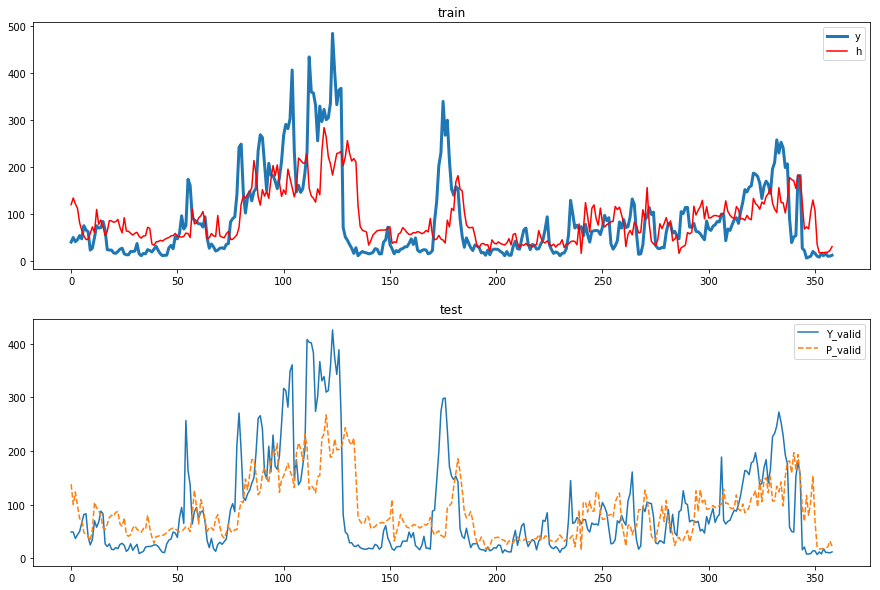

In [29]:
fig, axes = plt.subplots(2,1,figsize=(15,10))
show_time = 12
axes[0].plot(scaler_y.inverse_transform(y_train)[:,show_time],linewidth=3)
axes[0].plot(scaler_y.inverse_transform(predict_train)[:,show_time],c='r',linestyle='-')
axes[0].set_title('train')
axes[0].legend(['y','h'])

axes[1].plot(scaler_y.inverse_transform(y_test)[:,show_time])
axes[1].plot(scaler_y.inverse_transform(predict_test)[:,show_time],linestyle='--')
axes[1].set_title('test')
axes[1].legend(['Y_valid','P_valid'])

### 시간에 따른 오차입니다. 1시간 뒤의 예측은 비교적 정확하지만 미래로 갈수록 오차가 커집니다

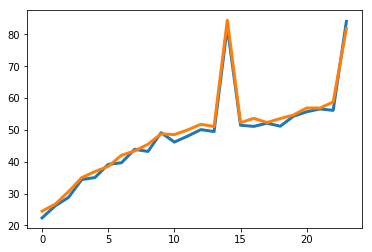

In [30]:

y_t = scaler_y.inverse_transform(y_train)
y_th = scaler_y.inverse_transform(predict_train)

y_e = scaler_y.inverse_transform(y_test)
y_eh = scaler_y.inverse_transform(predict_test)
error = np.mean(np.abs(y_t- y_th), 0)
plt.plot(error,linewidth=3)

error = np.mean(np.abs(y_e- y_eh), 0)
plt.plot(error,linewidth=3)
